In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import HashingVectorizer

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn. metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

###### List of files in the project directory for future reference

In [4]:
os.listdir()

['.DS_Store',
 '.git',
 '.github',
 '.ipynb_checkpoints',
 'Books_ratings_R_version',
 'books_rating_project_EDA_3.ipynb',
 'books_rating_project_EDA_Cleaning_1.ipynb',
 'books_rating_project_EDA_Cleaning_2.ipynb',
 'data',
 'Project_Description_ML_2023.docx.pdf',
 'Python_labs_project.ipynb',
 'README.md',
 'requirements.txt']

###### Data is kept seprate from the main project folder. Listing the data files that are available

In [5]:
os.listdir('data')

['books.csv',
 'cleaned_books.csv',
 'uncleaned_books.csv',
 'uncleaned_books.csv_bad_lines.txt',
 'working_books.csv']

###### For this part of the project, we will be working with the cleaned_books.csv (cleaned in earlier notebooks Cleaning 1 and 2. Future suggestions for cleaning will be updated in EDA_cleaning files so that the final working copy will always be cleaned_books.csv

In [6]:
folder = 'data/'
f_ratings = 'cleaned_books.csv'
ratings_path = folder + f_ratings

In [7]:
###### Note to self: potentially use this as a further cleaning file and end with a cleaner 
###### file of actual feature to be used in the model

In [8]:
df_ratings = pd.read_csv(ratings_path)
df_ratings.head()

,bookID,title,authors,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,4.78


###### Looking at the columns and looking ahead, we can safely guess we can drop the bookID column from consideration as a feature. We might be able to do something interesting with the title, if we were to do some extra nlp processing on the title, but that is beyond the scope of this iteration of the project. We might be able to make use of the author(s). There is currently some debate as to what affect the author of the book will have on the rating. isbn and isbn13 at first glance do not provide any information and will not be used in the current inquiry (as a side note, if we were to take the time to parse the isbn numbers, they actually provide interesting infromation such as the publisher, langauge published in, issuing agengy of the publication code, etc. but, much like the NLP work needed to parse the title, the parsing of isbn codes is beyond the scope of the current project. We might be able to do some work with language, ratings_count and text_reviews count and will be keeping those for the time being. publication date code be an interesting feature, but we would need more information (such as snapshots in time from publication date, whether a book is a reprint of a classic, if a new introduction from another author boosted popularity and therefore perception and sentiment, etc) so we will not be working with publication date during this project. Publisher could have something to do with average rating (again thinking along the lines of how marketing affects percepton of a book, or the cover of a book, etc)


In [9]:
###### Giving a list of the columns as they appear, both as a nice visual, and because sometimes, showing the list will actually
###### show hidden spaces in column names that might cause problems later *** note to self-clean up column names in future
###### iterations of EDA data cleaning
list(df_ratings.columns)

['bookID',
 'title',
 'authors',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'average_rating']

In [10]:
####### Creating a variable to store our working columns. Tried the difference trick used below, but it changed the 
####### ordering of the columns
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'average_rating']

In [11]:
df_ratings_keep = df_ratings[keep_cols]
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78


In [12]:
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)

In [13]:
def round_to_increment_5(number):
    '''Return the string version of the target rounded in .5% increments'''
    rounded_number = round(number / 0.5) * 0.5
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)
        
#### ***Note to self: consider changing these functions to return as floats, and then use astype to change to strings to more
####    easily switch between log reg problem to classification problem

In [14]:
def str_buckets(num: float) -> str:
    '''Group ratings roughly by the standard deviation coupled with human
       reasoning'''
    if num < 3.0:
        return 'not my favorite'
    if num >= 3.0 and num < 3.6:
        return 'fine'
    if num >= 3.6 and num < 4.3:
        return 'good'
    if num >= 4.3 and num < 4.6:
        return 'very good'
    if num >= 4.6:
        return 'excelent'


In [15]:
df_ratings_keep['target_10'] = df_ratings_keep['average_rating'].round(decimals=1)

C:\Users\joesa\AppData\Local\Temp\ipykernel_29580\3663998029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_10'] = df_ratings_keep['average_rating'].round(decimals=1)


In [16]:
df_ratings_keep['target_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)

C:\Users\joesa\AppData\Local\Temp\ipykernel_29580\1083081448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)


In [17]:
df_ratings_keep['target_50'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)

C:\Users\joesa\AppData\Local\Temp\ipykernel_29580\2689911333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_50'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)


In [18]:
df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=0)

C:\Users\joesa\AppData\Local\Temp\ipykernel_29580\2542177934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=0)


In [19]:
df_ratings_keep['target_str'] = df_ratings_keep['average_rating'].apply(str_buckets)

In [20]:
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating,target_10,target_25,target_50,target_1,target_str
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57,4.6,4.5,4.5,5.0,very good
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49,4.5,4.5,4.5,4.0,very good
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42,4.4,4.5,4.5,4.0,very good
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56,4.6,4.5,4.5,5.0,very good
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78,4.8,4.75,5.0,5.0,excelent


In [21]:
### Testing to see if model learns better when the outlier (in this case an outlier is considered a book with 0 ratings.
### We know that a book with 0 ratings will be the only books rated below a 1.0, but we don't know if these books share other
### features with more highly rated books)
df_ratings_drop_0 = df_ratings_keep.drop(df_ratings_keep[
    df_ratings_keep["ratings_count"] == 0].index, inplace=False)

In [22]:
lst_targets = ['.10', '.25', '.50', '1.0', 'Custom']
lst_f1 = []
lst_accuracy = []

# Testing with .10 buckets

In [23]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_10']

In [24]:
df_ratings_10 = df_ratings_keep[keep_cols_num]

In [25]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [27]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [28]:
logreg.fit(x_train, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [29]:
predictions = logreg.predict(x_test)

In [30]:
score = logreg.score(x_test, y_test)

In [31]:
score

0.16202455825097334

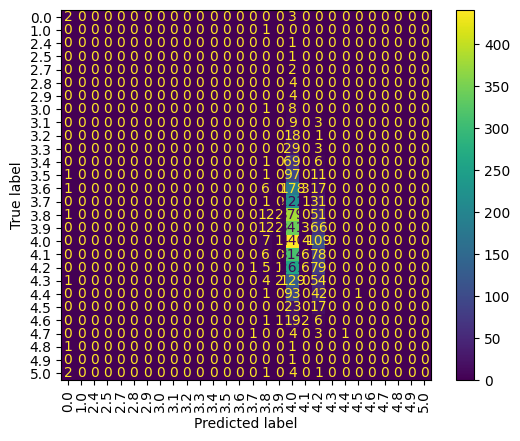

In [32]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)


In [33]:
clf = RandomForestClassifier(n_estimators=100)

In [34]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.1309371 , 0.15275995, 0.14505777, 0.13102119, 0.12588311])

In [35]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [36]:
predictions = clf.predict(x_test)

In [37]:
clf.score(x_test, y_test)

0.1296795447738844

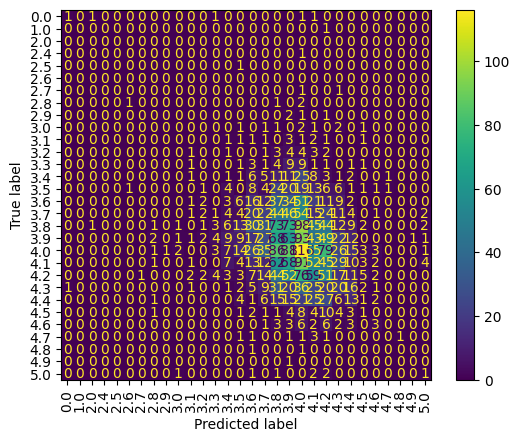

In [38]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

###### Here we test with books with 0 reviews removed from testing and training

In [39]:
df_ratings_10_drop = df_ratings_drop_0[keep_cols_num]

In [40]:
y = df_ratings_10_drop['target_10'].astype(str)
x = df_ratings_10_drop[df_ratings_10_drop.columns.difference(['target_10'])]

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [42]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [43]:
logreg.fit(x_train, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [44]:
predictions = logreg.predict(x_test)

In [45]:
score = logreg.score(x_test, y_test)
score

0.16264333132166567

###### And we see the tiniest of improvements in logistic regression

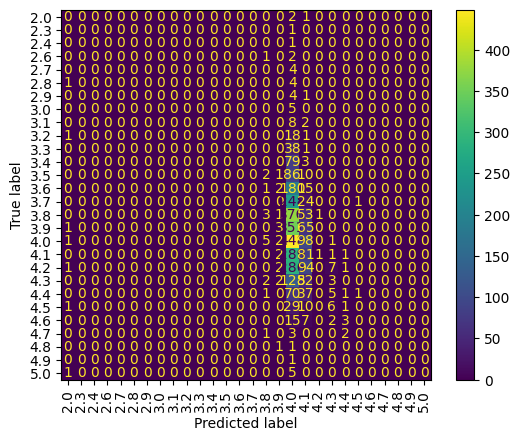

In [46]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [47]:
clf = RandomForestClassifier(n_estimators=100)

In [48]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.13639302, 0.12734324, 0.12871928, 0.12419146, 0.12936611])

###### And the tiniest of degradation of performance in RandomForest Classification

In [49]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [50]:
predictions = clf.predict(x_test)

In [51]:
clf.score(x_test, y_test)

0.13337356668678335

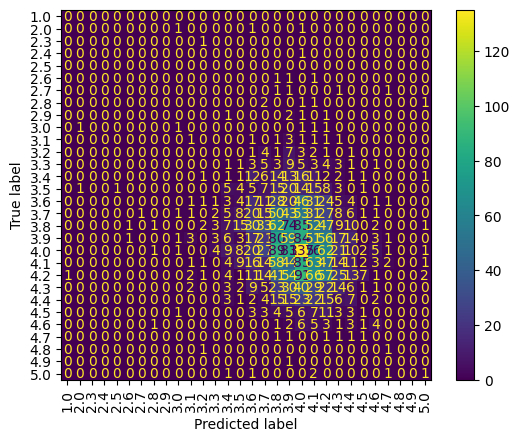

In [52]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

###### Here we start to introduce the categorical variables

In [53]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_10']

In [54]:
df_ratings_10 = df_ratings_keep[keep_cols]

In [55]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Isolate categorical features for encoding using the hash trick

In [57]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [58]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

### Create the vectorizers

In [59]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

### Vectorize the categorical vars and change them to arrays

In [60]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [61]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [62]:
num_feats_012 = ['  num_pages', 'ratings_count', 'text_reviews_count']
num_feats_01 = ['  num_pages', 'ratings_count']
num_feats_02 = ['  num_pages', 'text_reviews_count']
num_feats_0 = ['  num_pages']
num_feats_1 = ['ratings_count']
num_feats_2 = ['text_reviews_count']
num_feats_12 = ['ratings_count', 'text_reviews_count']


In [63]:
cat_feats_train_012 = [auths_train_arr, pubs_train_arr, langs_train_arr]
cat_feats_train_01 = [auths_train_arr, pubs_train_arr]
cat_feats_train_02 = [auths_train_arr, langs_train_arr]
cat_feats_train_0 = [auths_train_arr]
cat_feats_train_1 = [pubs_train_arr]
cat_feats_train_2 = [langs_train_arr]
cat_feats_train_12 = [pubs_train_arr, langs_train_arr]

cat_feats_test_012 = [auths_test_arr, pubs_test_arr, langs_test_arr]
cat_feats_test_01 = [auths_test_arr, pubs_test_arr]
cat_feats_test_02 = [auths_test_arr, langs_test_arr]
cat_feats_test_0 = [auths_test_arr]
cat_feats_test_1 = [pubs_test_arr]
cat_feats_test_2 = [langs_test_arr]
cat_feats_test_12 = [pubs_test_arr, langs_test_arr]

In [64]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[num_feats_012].values], axis = 1)

In [65]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[num_feats_012].values], axis = 1)

In [66]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [67]:
logreg.fit(train_feats, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [68]:
predictions = logreg.predict(test_feats)

In [69]:
score = logreg.score(test_feats, y_test)
score

0.1530398322851153

###### A slight degradation in performance with logreg when adding all categorical features

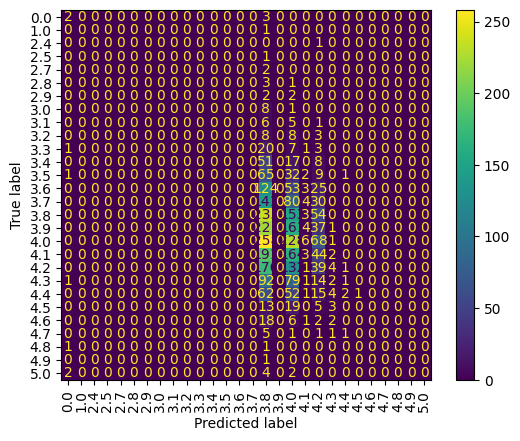

In [70]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)


In [71]:
clf = RandomForestClassifier(n_estimators=100, warm_start=True)

In [72]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.20539153, 0.19255456, 0.21437741, 0.20102762, 0.23185613])

###### But here we see a pretty big improvement in RandomForest Classifier when adding the categorical features (somewhere between 5% and almost 9% depending on the fold)

In [73]:
clf.fit(train_feats, y_train)

RandomForestClassifier(warm_start=True)

In [74]:
predictions = clf.predict(test_feats)

In [75]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         5
         1.0       0.00      0.00      0.00         1
         2.4       0.00      0.00      0.00         1
         2.5       0.00      0.00      0.00         1
         2.6       0.00      0.00      0.00         0
         2.7       0.00      0.00      0.00         2
         2.8       0.00      0.00      0.00         4
         2.9       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         9
         3.1       0.00      0.00      0.00        12
         3.2       1.00      0.05      0.10        19
         3.3       0.00      0.00      0.00        32
         3.4       0.19      0.08      0.11        76
         3.5       0.37      0.09      0.15       110
         3.6       0.19      0.13      0.15       205
         3.7       0.19      0.12      0.14       255
         3.8       0.20      0.27      0.23       445
         3.9       0.19    

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_projec

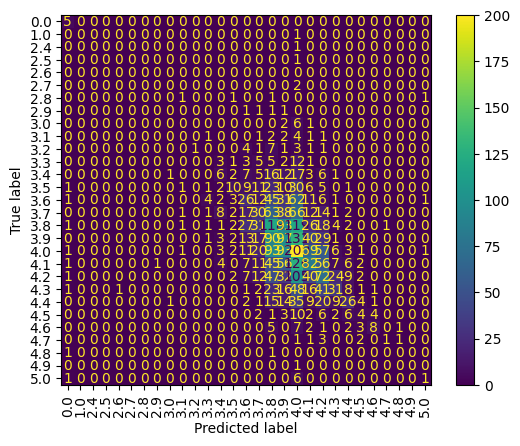

In [76]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)


###### Here we test with a couple of different combinations of input features

In [77]:
train_feats = np.concatenate([auths_train_arr, x_train[num_feats_0].values], axis = 1)
test_feats = np.concatenate([auths_test_arr, x_test[num_feats_0].values], axis = 1)

In [78]:
clf = RandomForestClassifier(n_estimators=150, max_features= 'sqrt', min_samples_split= 5)

In [79]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.2156611 , 0.22849807, 0.22272144, 0.21066153, 0.23442518])

In [80]:
clf.fit(train_feats, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=150)

In [81]:
predictions = clf.predict(test_feats)

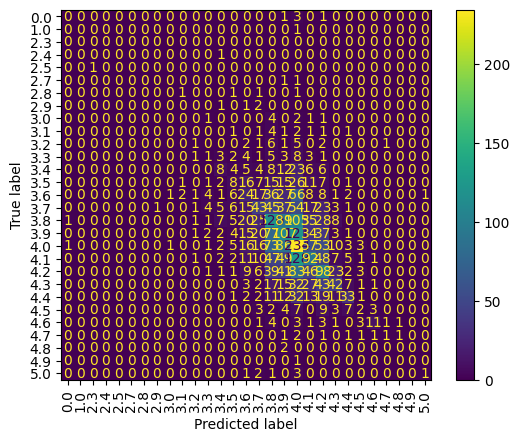

In [82]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [83]:
clf.score(test_feats, y_test)

0.24737945492662475

In [84]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.00      0.00      0.00         1
         2.3       0.00      0.00      0.00         0
         2.4       0.00      0.00      0.00         1
         2.5       0.00      0.00      0.00         1
         2.7       0.00      0.00      0.00         2
         2.8       0.00      0.00      0.00         4
         2.9       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         9
         3.1       0.00      0.00      0.00        12
         3.2       0.14      0.05      0.08        19
         3.3       0.06      0.03      0.04        32
         3.4       0.23      0.11      0.14        76
         3.5       0.17      0.07      0.10       110
         3.6       0.17      0.12      0.14       205
         3.7       0.26      0.17      0.21       255
         3.8       0.23      0.27      0.25       445
         3.9       0.21    

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_projec

In [85]:
####### Commenting this out until the pipeline can be functionized for more streamlined testing
####### df_ratings_10_drop = df_ratings_drop_0[keep_cols]
####### 
####### y = df_ratings_10_drop['target_10'].astype(str)
####### x = df_ratings_10_drop[df_ratings_10_drop.columns.difference(['target_10'])]

# Testing with .25 buckets

In [86]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_25']

In [87]:
df_ratings_25 = df_ratings_keep[keep_cols_num]

In [88]:
df_ratings_25.head()

,num_pages,ratings_count,text_reviews_count,target_25
0,652,2095690,27591,4.5
1,870,2153167,29221,4.5
2,352,6333,244,4.5
3,435,2339585,36325,4.5
4,2690,41428,164,4.75


In [89]:
y = df_ratings_25['target_25']
x = df_ratings_25[df_ratings_25.columns.difference(['target_25'])]

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [91]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [92]:
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [93]:
predictions = logreg.predict(x_test)

In [94]:
score = logreg.score(x_test, y_test)

In [95]:
score

0.3641808924827793

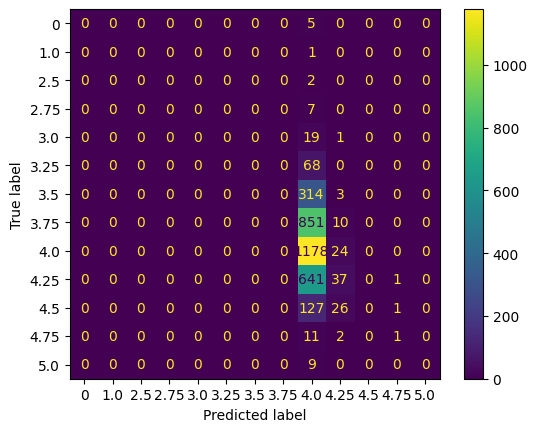

In [96]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)



In [97]:
clf = RandomForestClassifier(n_estimators=100)

In [98]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [99]:
scores

array([0.31771502, 0.33504493, 0.31964056, 0.31085421, 0.31663455])

In [100]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [101]:
predictions = clf.predict(x_test)

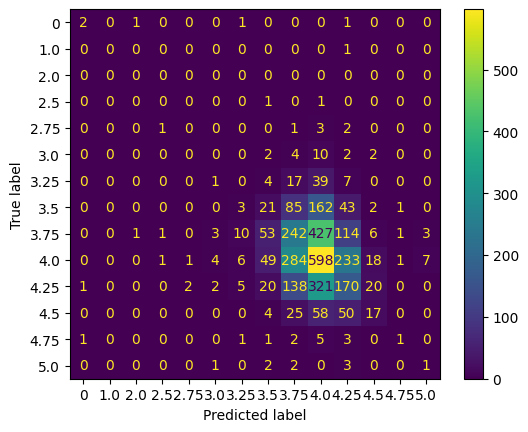

In [102]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [103]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_25']

In [104]:
df_ratings_25 = df_ratings_keep[keep_cols]

In [105]:
y = df_ratings_25['target_25'].astype(str)
x = df_ratings_25[df_ratings_25.columns.difference(['target_25'])]

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [107]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [108]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [109]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [110]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [111]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [112]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [113]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [114]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [115]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [116]:
logreg.fit(train_feats, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [117]:
predictions = logreg.predict(test_feats)

In [118]:
score = logreg.score(test_feats, y_test)
score

0.36058700209643607

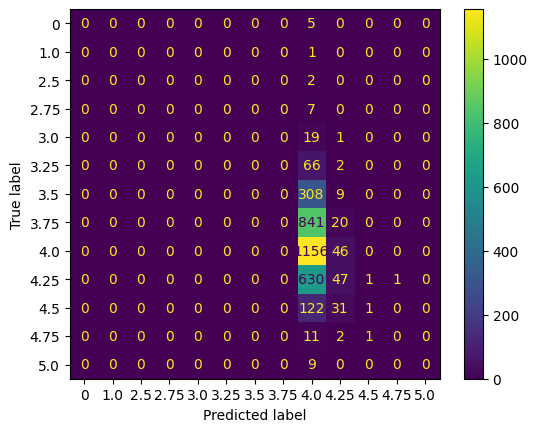

In [119]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [120]:
clf = RandomForestClassifier(n_estimators=100)

In [121]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.41720154, 0.41078306, 0.42169448, 0.41297367, 0.4091201 ])

In [122]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [123]:
predictions = clf.predict(test_feats)

In [124]:
clf.score(test_feats, y_test)

0.42946990116801437

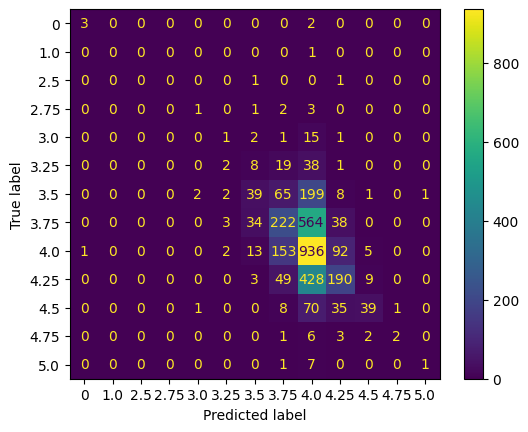

In [125]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [126]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
for i in range(len(precision)):
    print(i, precision[i], recall[i], f1[i], support[i])

0 0.75 0.6 0.6666666666666665 5
1 0.0 0.0 0.0 1
2 0.0 0.0 0.0 2
3 0.0 0.0 0.0 7
4 0.0 0.0 0.0 20
5 0.2 0.029411764705882353 0.05128205128205128 68
6 0.38613861386138615 0.12302839116719243 0.18660287081339713 317
7 0.42610364683301344 0.2578397212543554 0.32127351664254705 861
8 0.4125165271044513 0.778702163061564 0.5393258426966292 1202
9 0.5149051490514905 0.27982326951399117 0.3625954198473283 679
10 0.6964285714285714 0.2532467532467532 0.3714285714285714 154
11 0.6666666666666666 0.14285714285714285 0.23529411764705882 14
12 0.5 0.1111111111111111 0.1818181818181818 9


In [128]:
f1 = f1_score(y_test, predictions, average='micro')
f1

0.42946990116801437

# Testing with .5 buckets

In [129]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_50']

In [130]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_50']

In [131]:
df_ratings_50 = df_ratings_keep[keep_cols_num]

In [132]:
y = df_ratings_50['target_50']
x = df_ratings_50[df_ratings_50.columns.difference(['target_50'])]

In [133]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [134]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [135]:
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [136]:
predictions = logreg.predict(x_test)

In [137]:
score = logreg.score(x_test, y_test)

In [138]:
score

0.6549865229110512

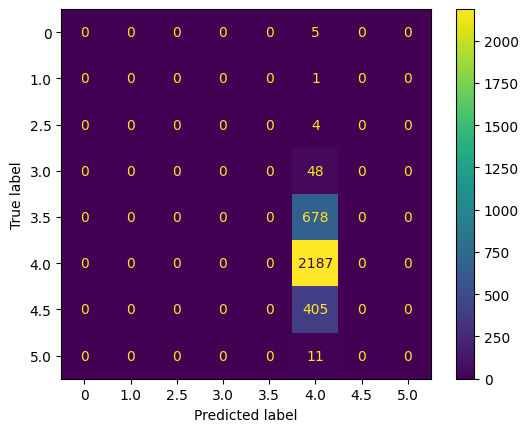

In [139]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [140]:
clf = RandomForestClassifier(n_estimators=100)

In [141]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [142]:
scores

array([0.63029525, 0.6097561 , 0.62644416, 0.62877328, 0.62235067])

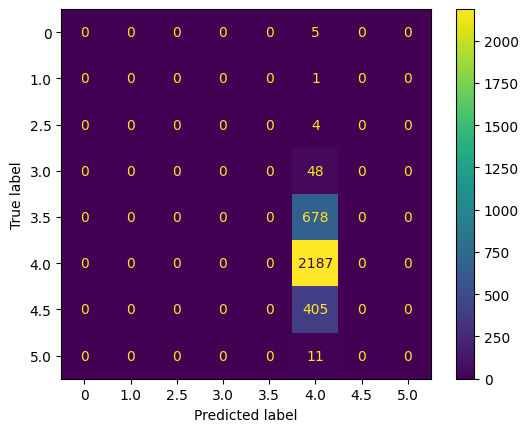

In [143]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [144]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [145]:
predictions = clf.predict(x_test)

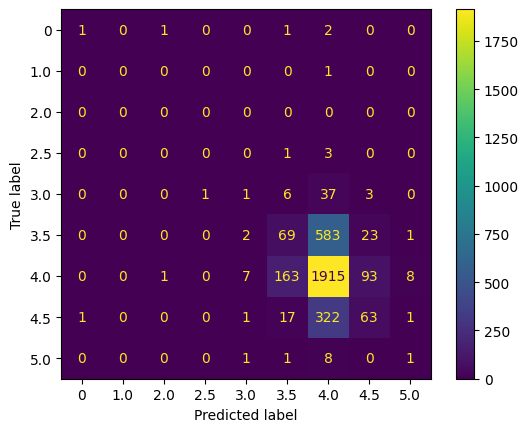

In [146]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [147]:
clf.score(x_test, y_test)

0.6139562743336329

In [148]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.5531463608376348

In [149]:
df_ratings_50 = df_ratings_keep[keep_cols]

In [150]:
y = df_ratings_50['target_50'].astype(str)
x = df_ratings_50[df_ratings_50.columns.difference(['target_50'])]

In [151]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [152]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [153]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [154]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [155]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [156]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [157]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [158]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [159]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [160]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [161]:
logreg.fit(train_feats, y_train)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [162]:
predictions = logreg.predict(test_feats)

In [163]:
score = logreg.score(test_feats, y_test)
score

0.6549865229110512

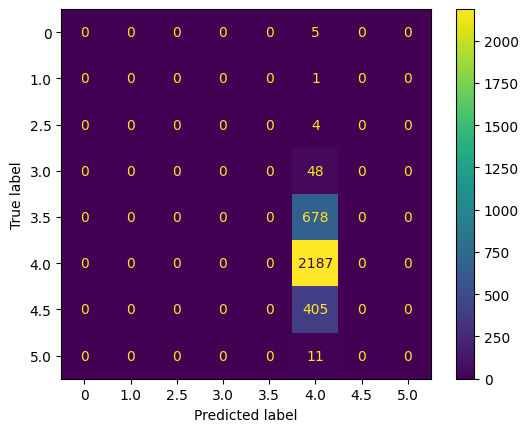

In [164]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [165]:
clf = RandomForestClassifier(n_estimators=100)

In [166]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.69127086, 0.68421053, 0.69512195, 0.68336545, 0.68272319])

In [167]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [168]:
predictions = clf.predict(test_feats)

In [169]:
clf.score(test_feats, y_test)

0.6840371368673256

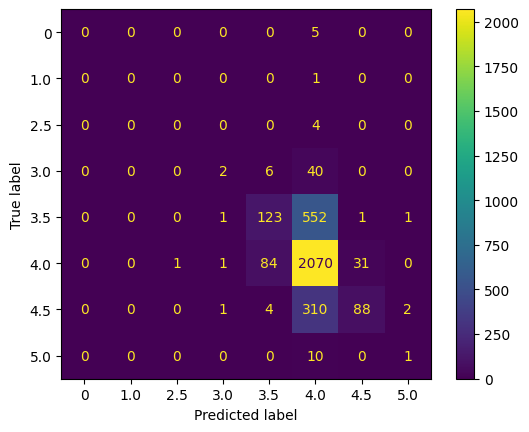

In [170]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [171]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.6215827315572584

# Testing with whole numbers

In [172]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_1']

In [173]:
df_ratings_1 = df_ratings_keep[keep_cols_num]

In [174]:
y = df_ratings_1['target_1']
x = df_ratings_1[df_ratings_1.columns.difference(['target_1'])]

In [175]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [176]:
clf = RandomForestClassifier(n_estimators=100)

In [177]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [178]:
scores

array([0.90629012, 0.90693196, 0.90949936, 0.90751445, 0.90494541])

In [179]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [180]:
predictions = clf.predict(x_test)

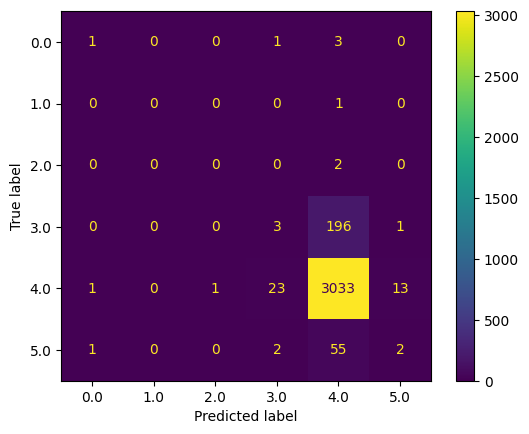

In [181]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)

In [182]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_1']

In [183]:
df_ratings_1 = df_ratings_keep[keep_cols]

In [184]:
y = df_ratings_1['target_1']
x = df_ratings_1[df_ratings_1.columns.difference(['target_1'])]

In [185]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [186]:
clf = RandomForestClassifier(n_estimators=100)

In [187]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [188]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [189]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [190]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [191]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [192]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [193]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [194]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [195]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [196]:
scores

array([0.91912709, 0.91463415, 0.91335045, 0.91843288, 0.91714836])

In [197]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [198]:
predictions = clf.predict(test_feats)

In [199]:
clf.score(test_feats, y_test)

0.9209344115004492

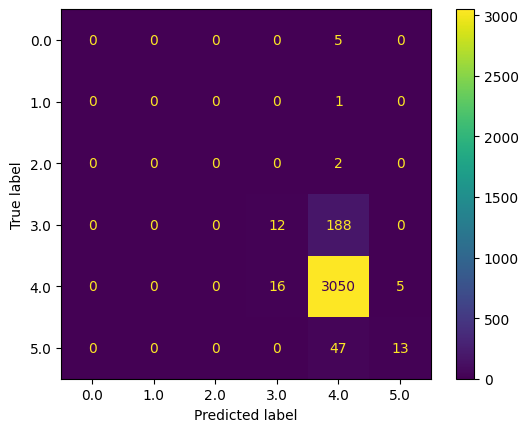

In [200]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [201]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.8938775929145668

# Testing with string buckets
## "not my favorite": < 3.0
## "fine": 3.0 - 3.6
## "good": 3.6 - 4.3
## "very good": 4.3 - 4.6
## "excelent": > 4.6

In [202]:
keep_cols_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_str']

In [203]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_str']

In [204]:
df_ratings_str = df_ratings_keep[keep_cols_num]

In [205]:
y = df_ratings_str['target_str']
x = df_ratings_str[df_ratings_str.columns.difference(['target_str'])]

In [206]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [207]:
clf = RandomForestClassifier(n_estimators=100)

In [208]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

array([0.78241335, 0.77599487, 0.77471117, 0.77970456, 0.77007065])

In [209]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [210]:
predictions = clf.predict(x_test)

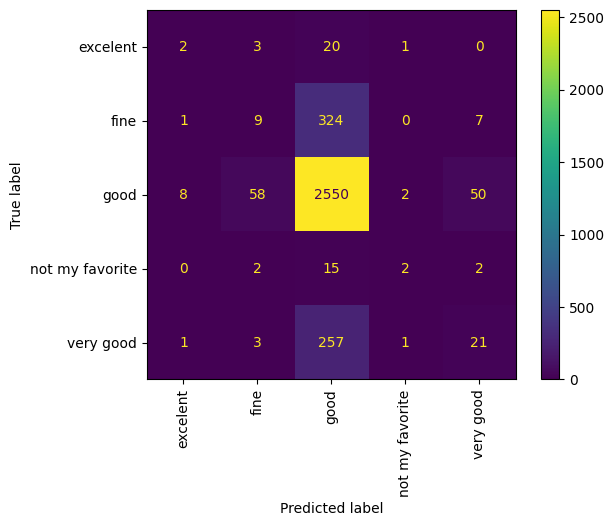

In [211]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [212]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.714487659938555

In [213]:
df_ratings_str = df_ratings_keep[keep_cols]

In [214]:
y = df_ratings_str['target_str']
x = df_ratings_str[df_ratings_str.columns.difference(['target_str'])]

In [215]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [216]:
clf = RandomForestClassifier(n_estimators=100)

In [217]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [218]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [219]:
vectorizer_auth =HashingVectorizer(n_features=1000)

vectorizer_pub = HashingVectorizer(n_features=1000)

vectorizer_lang = HashingVectorizer(n_features=1000)

In [220]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [221]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [222]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [223]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [224]:
test_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [225]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

array([0.80680359, 0.80872914, 0.81450578, 0.80732177, 0.80732177])

In [226]:
clf.fit(train_feats, y_train)

RandomForestClassifier()

In [227]:
predictions = clf.predict(test_feats)

In [228]:
clf.score(test_feats, y_test)

0.8119197364480384

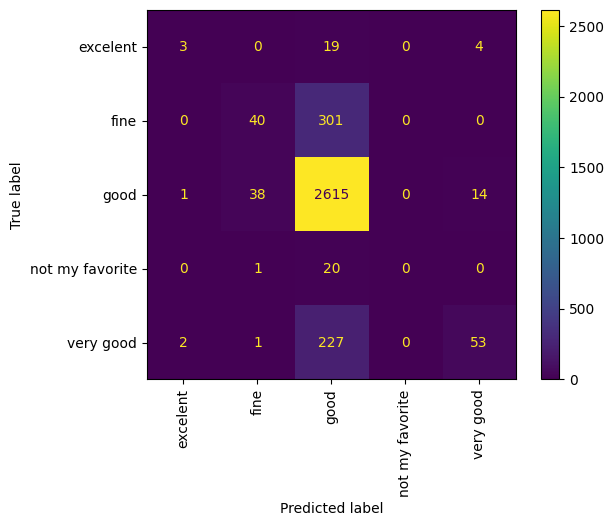

In [229]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [230]:
f1 = f1_score(y_test, predictions, average='weighted')
f1

0.7606022221007571

In [231]:
new_df = df_ratings_keep.drop(df_ratings_keep[
    df_ratings_keep["ratings_count"] == 0].index, inplace=False)